# 2018-12-10 - Using multiplicative weight STDP
Maybe this'll make the inhibitory work
It does with some manipulation of the excitatories, double check at the bottom

# Init

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None, do_title = True):
    #extracts the spiketrains
    spiketrain_len = []
    for spiketrain in np.asarray(spike_array.spiketrains):
        spiketrain_len.append(len(np.array(spiketrain, dtype = float)))
    spikelen_array = np.asarray(spiketrain_len)
    #fit the gaussian
    x = np.linspace(0, popsize,popsize)
    y = np.asarray(spikelen_array)

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws)
    
    #eye cancer-triggering lines
    sigma = r'$\sigma$ ' +out.fit_report(min_correl=.25).split('sigma')[1].split('+')[0]
    sigma = float(sigma.replace(' ', '').split(':')[1])
    
    if do_title :
        ax.set_title(r'$\sigma$ = '+str(sigma))
    
    return ax, sigma

def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, rates, simtime,
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        axs4 = plt.subplot(gs[: , 4:])
        
        #what a fucking mess
        min_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[0])
        max_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[1])
        axs1.set_ylim(min_poisson, max_poisson)
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        axs4.plot(rates * (simtime/1000), color = 'g', label = 'Input distribution')
        plt.legend()
        sigma = fit_plot(popsize, SpikesE, axs4)[1]
        
        axs4.set_xlabel('Neuron index')
        axs4.set_ylabel('Total spikes', rotation = 270)
        axs4.yaxis.tick_right()
        axs4.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig, sigma
    
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM

TODO : utiliser MultiplicativeWeightDependence pour les inhibiteurs

TODO : pour éviter une synchronie commencer avec 250ms de "je sais rien"= bruit uniforme 

# Now let's try one with all optimal parameters

In [3]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 90  # degrees
b_theta = 30  # degrees
sparseness = .1

In [4]:
sim.SpikePairRule?

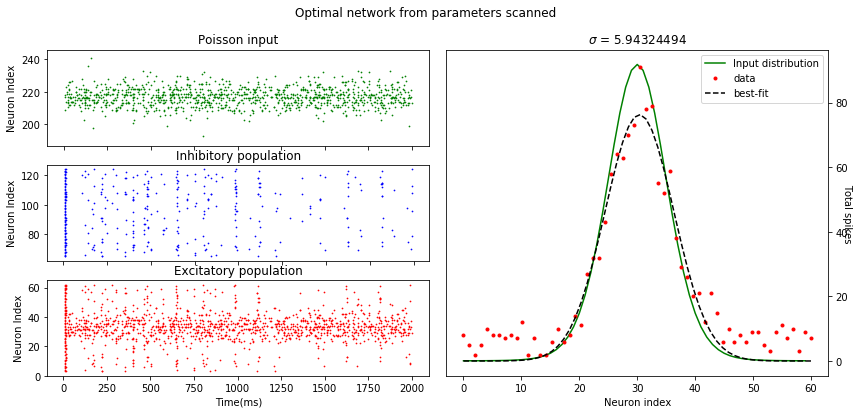

In [5]:
normal_weights = rnd('normal_clipped', mu=1.5, sigma=.2, low=0.1,
                     high=5,
                     rng=rng)

delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
             high=5,
             rng=rng)

timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                      A_plus=1, A_minus=10)
inh_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                      A_plus=-1, A_minus=-10)

stdp_weight_init = 1
stdp_max_w = 1

sim.setup(timestep=.1, threads=4)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=500, duration=simtime, start=0),
                           label="Entree Orientation")


STDP_syn = sim.STDPMechanism(
    timing_dependence=timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

inh_STDP_syn = sim.STDPMechanism(
    timing_dependence=inh_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=inh_STDP_syn,
                             receptor_type='excitatory') #ACTUALLY INHIBITORY DUE TO STDP STRUCTURE

# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_exc = sim.Projection(inh, exc,
                            connector=sim.FixedProbabilityConnector(
                                sparseness, rng=rng),
                            synapse_type=inh_STDP_syn,
                            receptor_type='excitatory') #ACTUALLY INHIBITORY DUE TO STDP STRUCTURE

# Input
syn_inp_exc = sim.Projection(input_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1),
                             receptor_type='excitatory')

angle = 1. * np.arange(n_pop)
rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
rates /= rates.mean()
rates *= rate_gain
for i, cell in enumerate(input_pop):
    cell.set_parameters(rate=rates[i])

exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime)
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig, sigma = SuperPlotter(inp_data, exc_data, inh_data,
                          60, rates, simtime,
                          title='Optimal network from parameters scanned',
                          figsize=(14, 6)
                          )

#fit_plot(n_pop, exc_data)

plt.show()

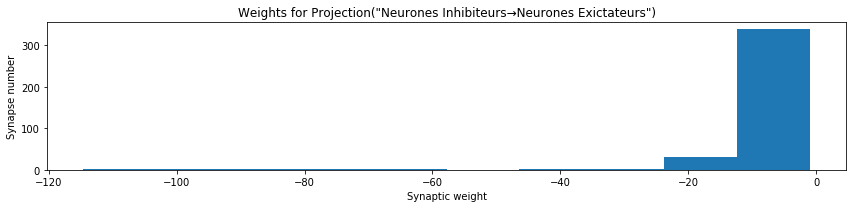

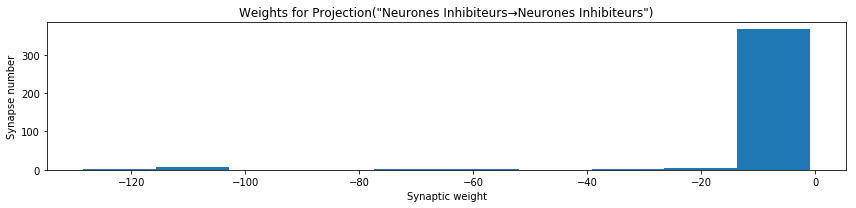

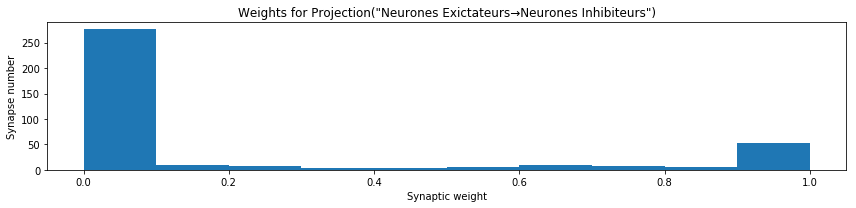

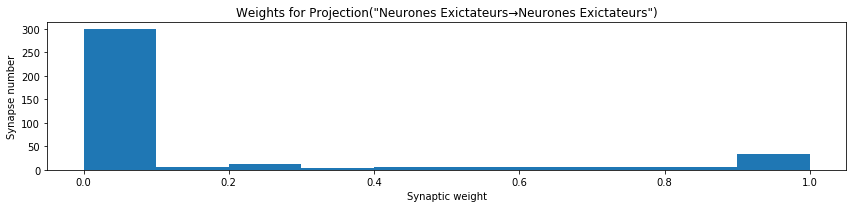

In [6]:
synapses = [syn_inh_exc,syn_inh_inh,syn_exc_inh,syn_exc_exc]

for syn in synapses :
    fig = plt.figure(figsize=(12, 3))

    weight_list = syn.get('weight', format='list')
    weight_only_list = []
    for neuron in weight_list:
        weight_only_list.append(neuron[-1])

    plt.hist(weight_only_list)
    plt.xlabel('Synaptic weight')
    plt.ylabel('Synapse number')
    plt.title(u'Weights for %s' % syn)
    
    plt.tight_layout()
    plt.show()
    plt.pause(.1)